In [1]:
# import relevant libraries
import numpy as np
import os
import re
import pathlib
import healpy as hp
import pickle
import matplotlib.pyplot as plt
import datetime
from impactClass import impactClass
from impactClass import impactClassList
import copy
from scipy.optimize import curve_fit
import pandas as pd
%matplotlib inline

def getGRSSegments(filenames, grs = 1):
    # Get list of segment times
    regex = r'(\d*)_grs%i.*'%(grs)
    segments = []
    for f in filenames:
        if re.match(regex, f):
            segments.append(int(re.findall(regex, f)[0]))
    return segments

In [2]:
# setup directory structure
p = pathlib.PurePath(os.getcwd())
BASE_DIR = str(p.parent)
dataDir = '/data'

In [3]:
# IRA
# I think the only change to be made is the directory, 
# for you it should be directory = '/data'
# This takes a little bit to load, ~ 1 minute, 
# do NOT try to load every segment, just the impacts
impactList = impactClassList(grs = 1, getValid = True, BASE_DIR = BASE_DIR, 
                             dataDir = dataDir, include_marginal = False,
                             directory = dataDir + '/ONLY_IMPACTS')


Reading through pickle files


Loading Valid Times
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


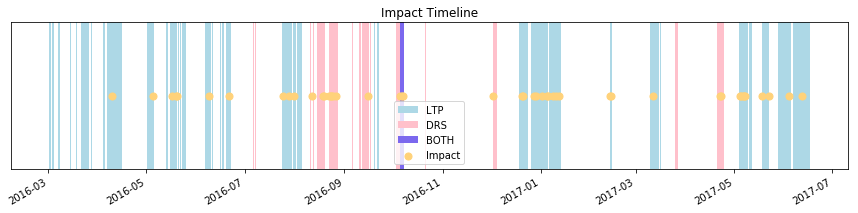

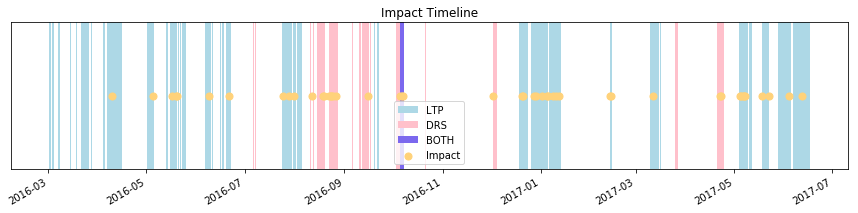

In [4]:
def getisGlitch(segment, df_veto):
    try:
        index = df_veto.index[df_veto['segment'] == int(segment)][0]
    except IndexError:
        # if not in the list, its not an Impact
        return False
    else:
        return df_veto['isGlitch'].values[index]

def getSearchTimes():
    search_times = pd.read_csv(BASE_DIR + '/scripts/segment_list_NEW.txt',
                               #dataDir + '/keyansegments.txt', 
                               #'/segment_list_NEW.txt',
            header = 'infer', delim_whitespace = True)
    
    return search_times

def getisValidSearch(segment, search_times):
    # search_times = pd.read_csv(BASE_DIR + dataDir + '/segment_list_NEW.txt',
    #        header = 'infer', delim_whitespace = True)
    try:
        index = search_times.index[search_times['segment'] == int(segment)][0]
    except IndexError:
        return False
    else:
        return True
    
def getisValidSearch_old(segment):
    search_times = pd.read_csv(BASE_DIR + dataDir + '/segment_list.txt',
            header = None, names = ['segment'], delim_whitespace = True)
    try:
        index = search_times.index[search_times['segment'] == int(segment)][0]
    except IndexError:
        return False
    else:
        return True


def isValid(segment, df_veto, search_times):
    # Both checks if the time searched is valid as well as 
    # if the time is a glitch

    if getisValidSearch(segment, search_times) and not getisGlitch(segment, df_veto):
        return True

    # If it's not in the segment list then its not a good segment
    return False

def get_start_stop(segments, seg_lens = None):
    segments = np.asarray(segments)
    sort = segments.argsort()
    segments = segments[sort]
    
    if seg_lens is not None:
        seg_lens = np.asarray(seg_lens)
        seg_lens = seg_lens[sort]

    start_stop = []
    i = 0
    while i < len(segments):
        start = segments[i]
        stop = 0
    
        count = 1
        while (stop == 0 and (i + count < len(segments))):
            if seg_lens is None:
                if start + 1648 * count + 5 > segments[i + count]:
                    count += 1
                else:
                    stop = segments[i + (count - 1)]
            else:
                if start + np.sum(seg_lens[i:(i + count)]) > segments[i + count]:
                    count += 1
                else:
                    stop = segments[i + (count - 1)]
                    
        if (i + count >= len(segments)):
            stop = segments[i + (count - 1)]
    
        if start == stop:
            if seg_lens is None:
                stop = start + 1648
            else:
                stop = start + seg_lens[i]
        
        start_stop.append([start, stop])
    
        i += count
    return start_stop

def timeline(self, dataDir  = dataDir, timeDir = BASE_DIR + '/data/observed_times',
             filenames = ['DRSlistDec.txt', 'LTPCMNTlist.txt', 'LTPlist2.txt'],
             segments = None):

    #import datetime
    #import time
    from astropy.time import Time
    
    #segments = np.loadtxt(BASE_DIR + dataDir + '/' + segment_file)
    
    def formatTime(gps):
        t0 = Time(gps, format='gps')
        t0 = Time(t0, format='iso')
        return t0.datetime
    
    print("Loading Valid Times")
    
    fig, ax = plt.subplots(figsize = (15, 3))
    ax.set_title('Impact Timeline')
    ax.yaxis.set_ticks_position('none') 

    regex = r'g_(\d+)_(\d+).tar.gz'
    j = 0
    colors = ['r', 'b', 'g']
    
    search_times = getSearchTimes()
    
    
    LTP = search_times[search_times['control'] == 'LTP'].reset_index()
    DRS = search_times[search_times['control'] == 'DRS'].reset_index()
    BOTH = search_times[search_times['control'] == 'BOTH'].reset_index()
    
    controls = [LTP, DRS, BOTH]
    
    # Plot segments
    
    for c in controls:
        print(type(c))
        name = c['control'].values[0]
        if name == 'LTP':
            color = 'lightblue'
        elif name == 'DRS':
            color = 'pink'
        else:
            color = 'mediumslateblue'
            
        start_stop = get_start_stop(c['segment'], seg_lens = c['length'])
        
        for i, ss in enumerate(start_stop):
            t0 = formatTime(ss[0])
            t1 = formatTime(ss[1])
                
            if i == 0:
                ax.axvspan(t0, t1, facecolor = color, alpha = 1, 
                           label = name)
            else:
                ax.axvspan(t0, t1, facecolor = color, alpha = 1)

    #Plot impacts
    for i, impact in enumerate(self.impact_list):
        if i == 0: 
            ax.scatter(formatTime(impact.gps), .5, color = '#ffd27a', 
                       label = 'Impact', marker = 'o', s = 50, zorder = 10)
        else:
            ax.scatter(formatTime(impact.gps), .5, color = '#ffd27a', 
                       marker = 'o', s = 50, zorder = 10)
    
    fig.autofmt_xdate()
    ax.yaxis.set_ticklabels([])

    # OLD 
    direc = "/Users/shouriha/LISAPathfinder/scripts/Analysis/data/OLD/OLD_TIMES_0526"
    df_veto = impactList.impact_list[0].getVetoList()
    search_times = getSearchTimes()
    for root, dirs, files in os.walk(direc):
        filenames = files
    old_impact_inv = getGRSSegments(filenames)
    
    old_impact = []
    for o in old_impact_inv:
        if isValid(o, df_veto, search_times) and getisValidSearch_old(o):
            #not getisGlitch(o, df_veto):
            old_impact.append(o)
        else:
            print(o, 'not Valid')

    ax.legend()

    return fig
    
    




timeline(impactList)

In [5]:
regex = r'.*g_(\d+)_(\d+).tar.gz'
timeDir = BASE_DIR + '/data/observed_times'
filenames = ['DRSlistDec.txt', 'LTPCMNTlist.txt', 'LTPlist2.txt']
write_file = open('segment_list_NEW.txt', 'w+')
write_file.write('segment\tlength\tcontrol\n')

class seg:
    def __init__(self, segment, length, command):
        self.segment = segment
        self.length = length
        self.command = command
        return

segs = []
for files in filenames:
    t_file = timeDir +'/' + files
    with open(t_file) as f:
        content = f.readlines()
        
    if files == 'DRSlistDec.txt':
        command = 'DRS'
    elif files == 'LTPCMNTlist.txt':
        command = 'BOTH'
    else:
        command = 'LTP'
            
    t0s = [int(re.findall(regex, c)[0][0]) for c in content]
    seg_len = [int(re.findall(regex, c)[0][1]) for c in content]
    
    for i in range(len(t0s)):
        segs.append(seg(t0s[i], seg_len[i], command))
            
    for i in range(len(t0s)):
        write_file.write('%i\t%i\t%s\n'%(t0s[i], seg_len[i], command))
write_file.close()

In [6]:
def getObservedTime(segment, dt = 0):
    #dt is time from start of segment
    searchTimes = getSearchTimes()
    searchTimes = searchTimes.sort_values('segment').reset_index()
    searchTimes['total'] = searchTimes.length.cumsum()
    
    line = searchTimes.loc[searchTimes['segment'] == segment]
    return line['total'].values[0]

obsTime = np.zeros(np.size(impactList.impact_list))
for idx, impact0 in enumerate(impactList.impact_list):
    obsTime[idx] = getObservedTime(impact0.segment, impact0.gps - impact0.segment)
    
print(obsTime)

[  1362816.   2245698.   2504502.   2717442.   2764944.   3441438.
   3909906.   4380535.   4714687.   4893229.   5388957.   6216774.
   6373522.   6519444.   6675513.   6749223.   6940221.   7229571.
   8337535.   9073778.   9145850.   9206456.   9363704.   9914072.
   9981230.  10402196.  10474268.  10782212.  11085242.  11126192.
  11412842.  11527502.  11732252.  11815790.  11846912.  12095888.
  12886043.  12889319.  13136657.  13213643.  13297181.  13374167.
  13426583.  13705043.  14026091.  14664911.  15212003.]


[ 3.53320738]
[ 0.05669159]


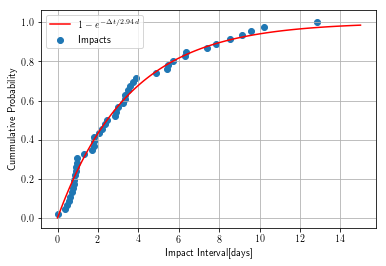

In [11]:
dx = np.diff(obsTime)
dxf = np.sort(dx)/86400.0
N = np.size(dx)

n = np.arange(1,N+1)/(N)


def exp_rise(x, lamb):
    return 1 - np.exp(-x/lamb)

popt, pcov = curve_fit(exp_rise, dxf, n)
print(popt)
perr = np.sqrt(np.diag(pcov))
print(perr)

xdata = np.linspace(0,15,100)
plt.rc('text', usetex=True)
plt.plot(xdata, exp_rise(xdata, popt), 'r-')
plt.scatter(dxf,n)
plt.xlabel('Impact Interval[days]')
plt.ylabel('Cummulative Probability')
plt.legend(['$1-e^{-\Delta t/2.94\,d}$','Impacts'])
plt.grid()
plt.savefig('rateplot.eps')



In [12]:
Pmed = np.zeros(np.size(impactList.impact_list))
for idx, impact0 in enumerate(impactList.impact_list):
    Pmed[idx] = np.median(impact0.Ptot)
    
print(Pmed)



[  17.2439      1.70458    14.3609      0.868524    2.0234      1.04929
    3.53687     2.87719    19.90045     8.59349     2.36781     1.5869
   12.1315      0.73212    23.8412      0.880261    3.04177     0.57464
    1.08954     0.852071  230.301       6.35836     0.641297    7.95639
    1.62414    28.6351      0.809875   22.5077      0.917909   10.3189
    4.51594     3.46537     1.23052     1.820925    2.47941     1.9271
    1.04549     1.13761     1.27266    40.1941      1.497       1.15813
   11.6822     13.9751      7.9972      1.24621     0.967592]


[  2717442.   3441438.   6519444.   6749223.   7229571.   8337535.
   9073778.   9363704.  10474268.  11085242.  11732252.  12886043.
  12889319.  13374167.  15212003.]
[  2245698.   2764944.   3909906.   4380535.   5388957.   6216774.
   6940221.   9981230.  11527502.  11815790.  11846912.  12095888.
  13136657.  13297181.  14664911.]
[  1362816.   2504502.   4714687.   4893229.   6373522.   6675513.
   9145850.   9206456.   9914072.  10402196.  10782212.  11126192.
  11412842.  13213643.  13426583.  13705043.  14026091.]


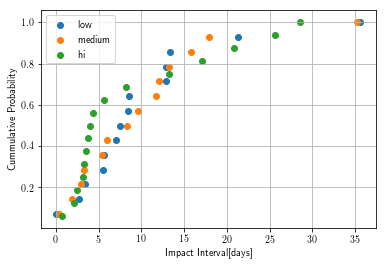

In [19]:
isort = np.argsort(Pmed)
N = np.size(isort)
Nchunk = np.floor(N/3.0)
obsTimeLow = np.sort(obsTime[isort[0:np.int(Nchunk)]])
obsTimeMed = np.sort(obsTime[isort[np.int(Nchunk):2*np.int(Nchunk)]])
obsTimeHigh = np.sort(obsTime[isort[2*np.int(Nchunk):np.int(N)]])
print(obsTimeLow)
print(obsTimeMed)
print(obsTimeHigh)

dxlow = np.diff(obsTimeLow)
dxflow = np.sort(dxlow)/86400.0
Nlow = np.size(dxlow)
dxmed = np.diff(obsTimeMed)
dxfmed = np.sort(dxmed)/86400.0
Nmed = np.size(dxmed)
dxhi = np.diff(obsTimeHigh)
dxfhi = np.sort(dxhi)/86400.0
Nhi = np.size(dxhi)



nlow = np.arange(1,Nlow+1)/(Nlow)
nmed = np.arange(1,Nmed+1)/(Nmed)
nhi = np.arange(1,Nhi+1)/(Nhi)
plt.scatter(dxflow,nlow)
plt.scatter(dxfmed,nmed)
plt.scatter(dxfhi,nhi)
plt.xlabel('Impact Interval[days]')
plt.ylabel('Cummulative Probability')
plt.legend(['low','medium','hi'])
plt.grid()
